イントロダクション


このノートブックでは、与えられたデータセットに関する基本情報を試してみましょう。 
このコンペのデータセットは、時間の経過とともに顧客の注文を記述するファイルのリレーショナルセットです。


---------
**目的：**
目的は、どの製品がユーザーの次の注文になるかを予測することです。 

---------
このデータセットは匿名化されており、Instacartの200,000人以上のユーザーから300万件を超えるサンプルを提供しています。
各ユーザーに対して、各注文で購入されたのは4から100の注文となっています。


---------
必要なモジュールをインポートすることから始めましょう。

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

コンペで使うファイルの一覧を作りましょう！ (今回はファイルがzipになっていたのでunzipで解凍済）

In [5]:
#check_output 引数でlinuxコマンドを実行し、その出力を返します。
#./で一個上のディレクトリをいきなり指せる（Users/szk...を書かなくて良い！）
from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

EDA-2-instacart.ipynb
__MACOSX
aisles.csv
aisles.csv.zip
departments.csv
departments.csv.zip
order_products__prior.csv
order_products__prior.csv.zip
order_products__train.csv
order_products__train.csv.zip
orders.csv
orders.csv.zip
products.csv
products.csv.zip
sample_submission.csv
sample_submission.csv.zip



探索的分析に入る前に、与えられたファイルについて確認しましょう。データフレームにすると良いです。

In [9]:
order_products_train_df = pd.read_csv("./order_products__train.csv")
order_products_prior_df = pd.read_csv("./order_products__prior.csv")
orders_df = pd.read_csv("./orders.csv")
products_df = pd.read_csv("./products.csv")
aisles_df = pd.read_csv("./aisles.csv")
departments_df = pd.read_csv("./departments.csv")

In [17]:
# .headで数行を返す
orders_df.head() 

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [12]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



* orders.csvには、注文を購入したユーザー、注文した日、前の注文日などのような、指定した注文IDに関するすべての情報が含まれています。
* order_products_trainとorder_products_priorにあるカラム名は同じです。では、これらのファイルの違いは何でしょう。前述のように、このデータセットでは、4から100の注文が与えられ、再注文される製品を予測する必要があります。ユーザーの最後の注文が取り出され、トレーニングとテストに分かれています。 
* order_products_priorファイルには、顧客のすべての事前注文情報が含まれています。
* また、eval_setと呼ばれるorders.csvファイルには、与えられた行がどの3つのデータセット（事前、トレーニング、またはテスト）のどれに向いているかを示す列があります。
* Order_products * csvファイルには、指定された順序で購入された製品に関する詳しい情報と、並べ替えられた状態が含まれています。
---------
最初に、3つのセットのそれぞれの行の数を取得しましょう。

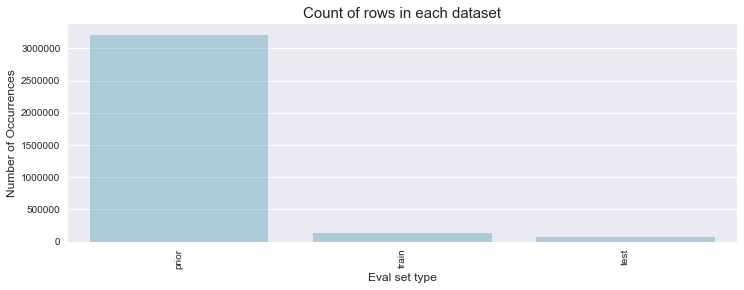

In [32]:
#自分でちょこちょこ表示を変更した。

# valu_counts()でorders_dfのeval_setカラムの行数を取得
cnt_srs = orders_df.eval_set.value_counts()

# plot figureで図に変換しfigsizeで縦横の大きさを指定
plt.figure(figsize=(12,4))

#Seabornのbarplotで棒グラフの出力 alphaは透明度(もとよりちょっと透明度を上げ、色も変えた）
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.5, color=color[5])

#Pltでラベルやタイトルの設定表示
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)

#x軸のrotation（ラベルの位置）verticalで垂直
plt.xticks(rotation='vertical')
plt.show()

In [46]:
#np.uniqueは要素の重複をなくしたものを返します。
def get_unique_count(x):
   return len(np.unique(x))

#groupby()でorders_dfのeval_setカラムでグルーピング。aggregate()でuser_idをカウント（ここでsum()を使うとuser_idの数字を全部足してしまう。ここでcount()を使うと、ただのorders_df.groupby("eval_set")のカウントつまり行カウントするだけになる）
cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

合計206,209人の顧客がいる。

そのうち、131,209人の顧客の最後の購入がtrainとして与えられ、残りの75,000人の顧客を予測する必要があります。
今度は、顧客の4から100件の注文が与えられたという主張を検証しましょう。

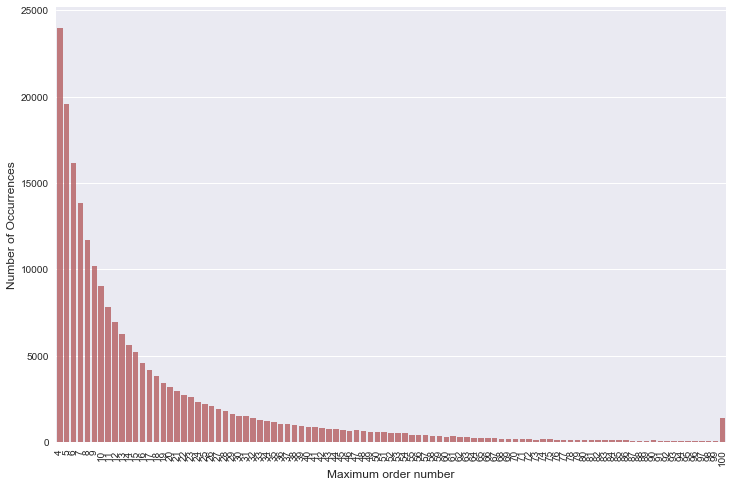

In [61]:
#reset_index()はデータを削除したり並べ替えたあとにデータフレームの左辺のインデックスを振り直すメソッドです。
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

検証の結果、4未満の注文はなく、指定されているように、100が上限になります。
さて、次は曜日によって注文が変わるかを見てみましょう。

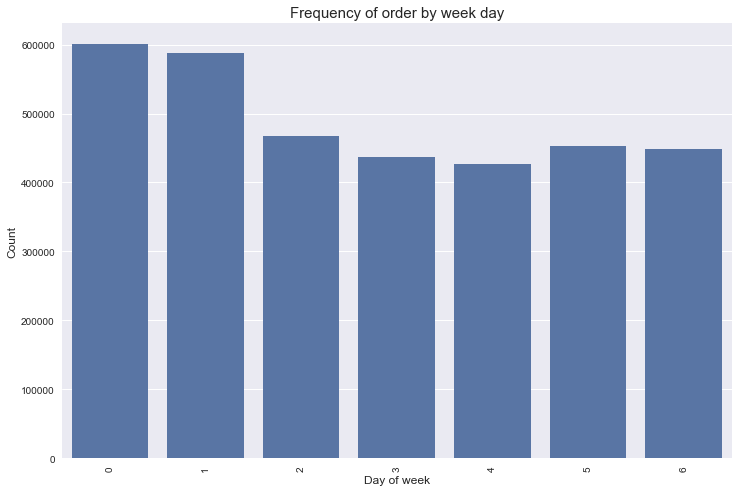

In [62]:
##countplotメゾットはY軸の数値を、X軸に該当するデータのカウントが出来ます。　
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

0と1のようなものは土曜日と日曜日です。水曜が一番低い受注カウントです。
さて、次は時間別分布です。

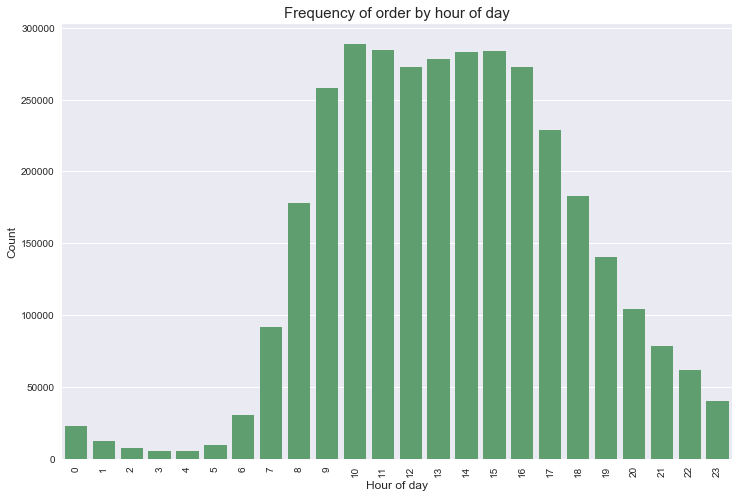

In [63]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

デイタイムのオーダーがマジョリティです。

さて、そしたら曜日と時間を混ぜて見ましょう。

---------

ヒートマップです。

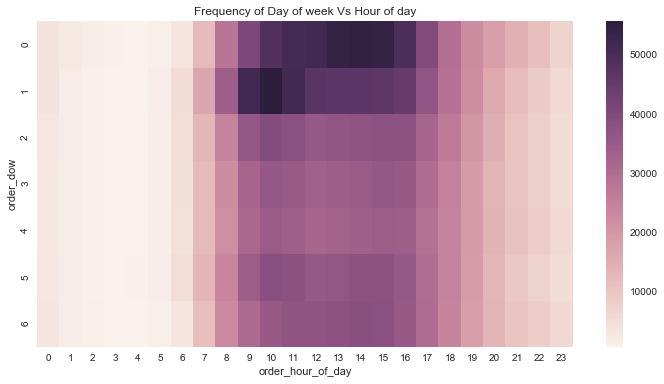

In [64]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

土曜の午後、日曜の午前が一番のタイミングですね。


次は、オーダーのインターバルを見て見ましょう。


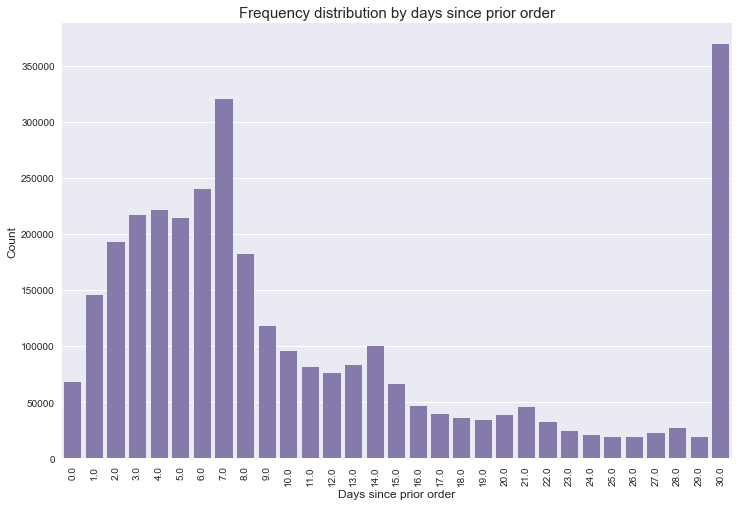

In [65]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

顧客は毎週1回（ピークを7日で確認）または1ヶ月に1回（30日でピーク）のように見えます。 
また、14日、21日および28日（週ごとの間隔）でより小さいピークを見ることができた。

---------

私たちの目的は再注文を把握することなので、PriotセットとTrainセットの再注文率をチェックしてみましょう。


In [67]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [68]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

平均して、オーダー内の製品の約59％が再オーダーされた製品です。

**再オーダーされない商品とは:**

再注文された商品がない場合もあります。 今すぐ確認しましょう。

In [70]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [71]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

Priorのセットでは、注文の約12％は再注文品が0、つまりありませんが、Trainセットでは6.5％です。
さあ、各注文で買った商品の数を見てみましょう。

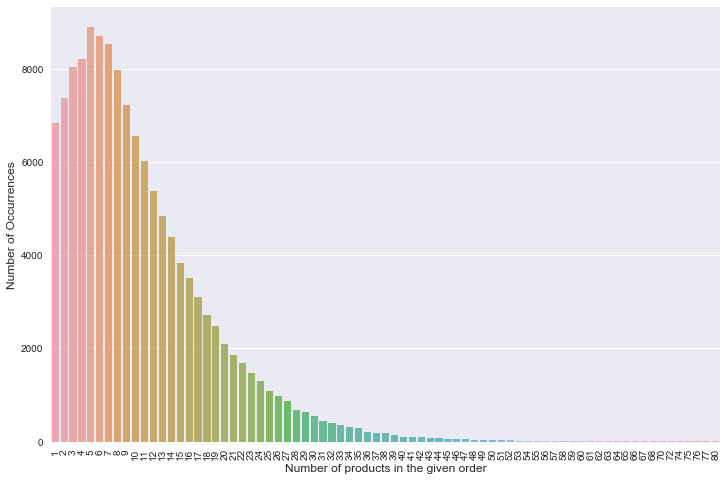

In [72]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

最大値が5で、そこから80までのテールの分布です。

製品の詳細を調べる前に、他の3つのファイルも見てみましょう。

In [73]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [74]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [75]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


order_priorにこれからの商品情報をマージしてしまいましょう。

In [76]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [78]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


ほとんどがorganic productsでした！しかもその中心はフルーツです。

では、アイル別のデータも見ておきましょう。

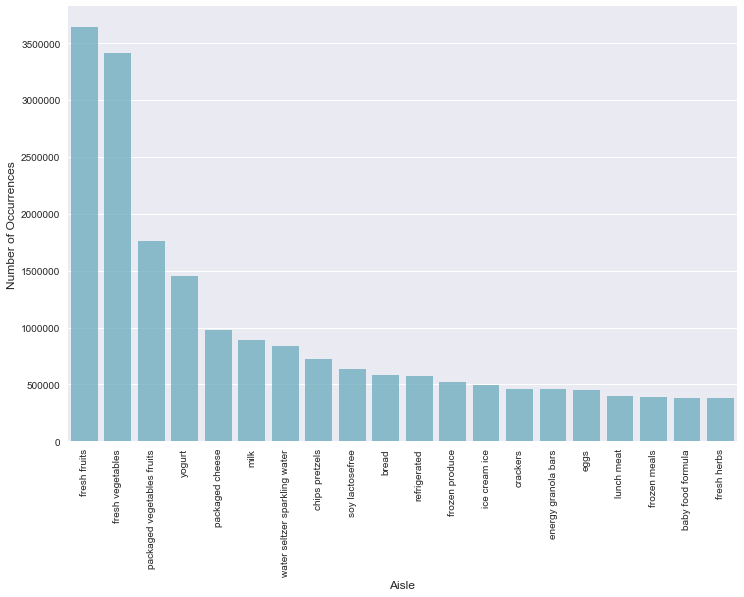

In [81]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

生鮮フルーツ、野菜がツートップです。

**Department Distribution:**

部署ごとに見ましょう！

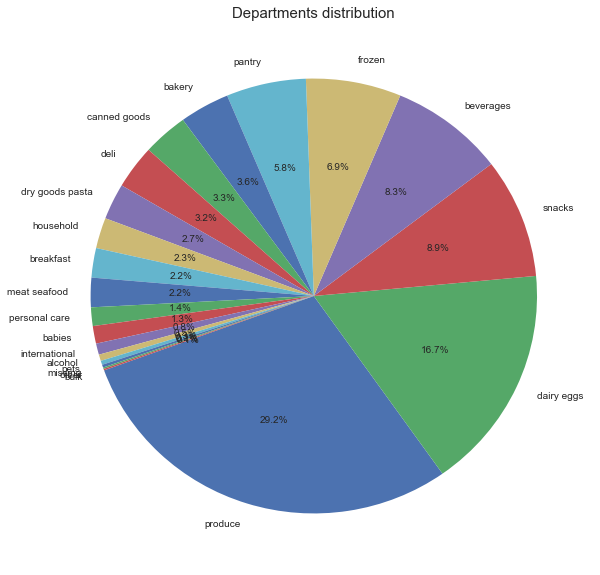

In [82]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

プロデュース部門が最大です。



**部門別再オーダー比率:**

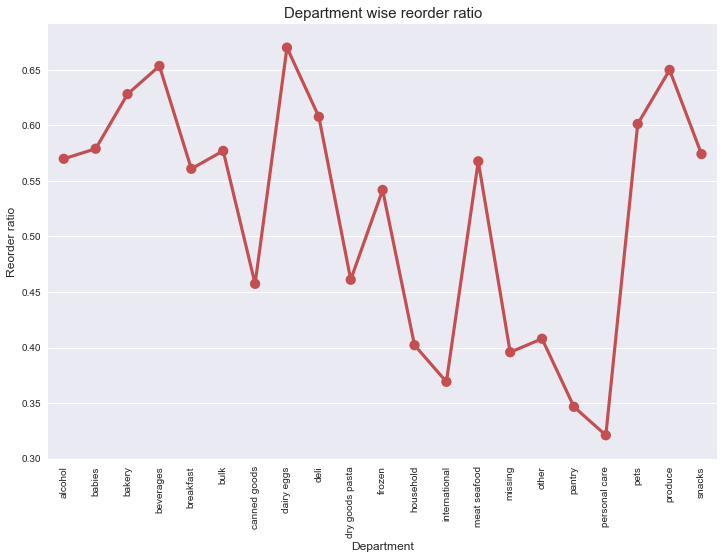

In [83]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

パーソナルケアプロダクトは、一番低い再オーダー率です。一方、卵は一番高い再オーダー率です。
**アイル別　再オーダー率:**

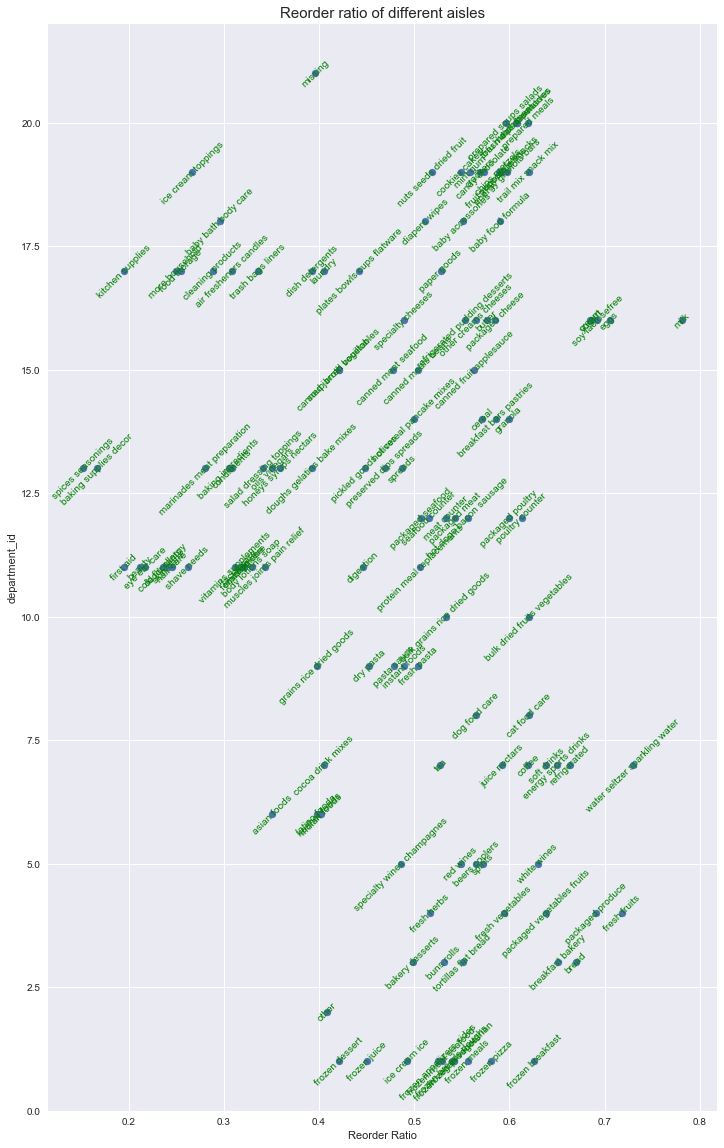

In [84]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

**「カートに入れる」再オーダー率:**

次は、カートに入れるということが、どれだけ再オーダー率に影響があるか見て見ましょう。

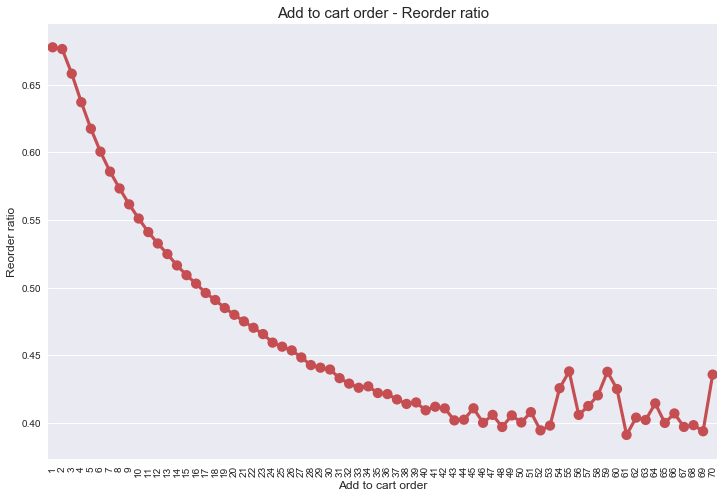

In [85]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**最初にカートに追加された商品は、後で追加される商品と比較して、再注文される可能性が高いようです。**

これは私が頻繁に購入していたすべての製品を最初に注文し、次に新しい製品を探し出す傾向があるため、私にとっても意味があります。
**時間ベース変数による並べ替え率：**


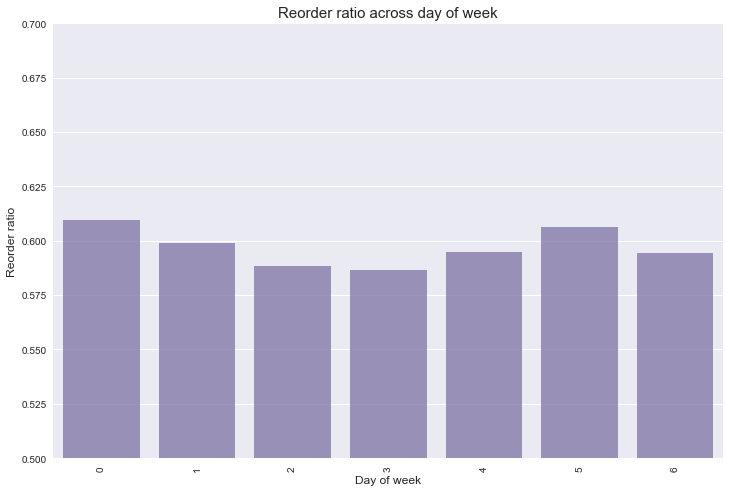

In [86]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

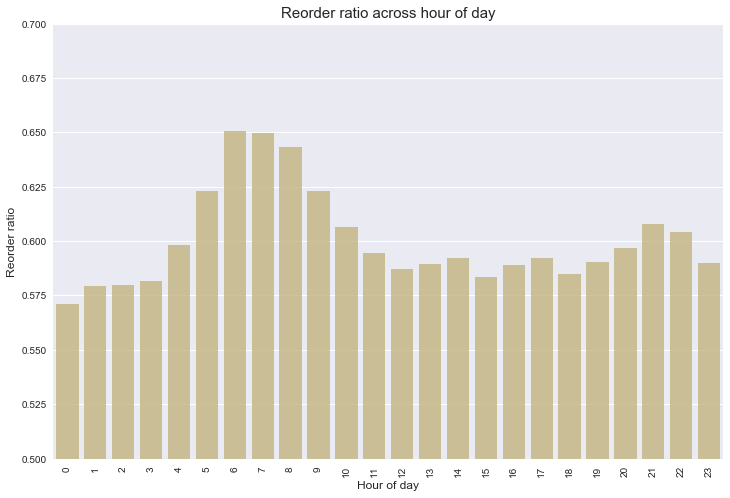

In [87]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

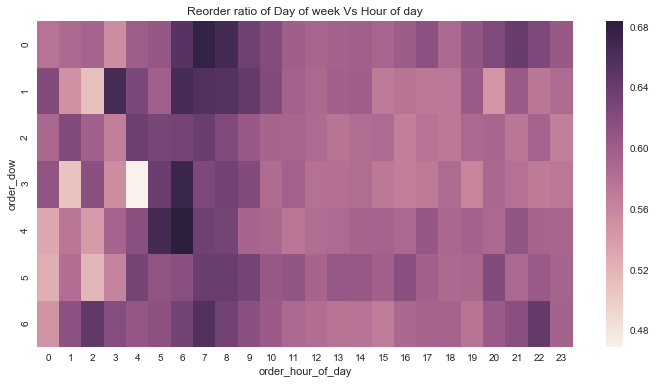

In [88]:

grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

早朝の再注文率は、後半の半分に比べてかなり高いようです。